# ReposVul

In [1]:
# If your venv already has these, you can skip this cell.
%pip install pandas orjson ujson matplotlib tqdm tabulate networkx python-levenshtein


^C
Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 27.3 MB/s  0:00:00

   ------ --------------------------------- 1/6 [tabulate]
   ------ --------------------------------- 1/6 [tabulate]
   ------------- -------------------------- 2/6 [rapidfuzz]
   ------------- -------------------------- 2/6 [rapidfuzz]
   ------------- -------------------------- 2/6 [rapidfuzz]
   ------------- -------------------------- 2/6 [rapidfuzz]
   ------------- -------------------------- 2/6 [rapidfuzz]
   ------------- -------------------------- 2/6 [rapidfuzz]
   ------------- -------------------------- 2/6 [rapidfuzz]
   -------------------------- ------------- 4/6 [Levenshtein]
   ---------------------------------------- 6/6 [python-levenshtein]



In [ ]:
from pathlib import Path
import json, orjson, ujson, re, difflib, itertools, math
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, defaultdict
from tqdm import tqdm

DATA_DIR = Path(r"../data/dataset/ReposVul_c_cpp")

FILES = {
    "train": DATA_DIR / "train_c_cpp_repository2.jsonl",
    "valid": DATA_DIR / "valid_c_cpp_repository2.jsonl",
    "test" : DATA_DIR / "test_c_cpp_repository2.jsonl",
}
for split, p in FILES.items():
    assert p.exists(), f"Missing: {split} → {p}"
print("All files exist.")

All files exist.


# 1. Sanity Check - Quick sanity checks (line counts, empty lines, JSON validity)

In [15]:
def count_lines(fp: Path, peek_n=3):
    n = 0; samples=[]
    with fp.open("r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f, 1):
            if line.strip():
                n += 1
                if len(samples) < peek_n:
                    samples.append(line[:300])
    return n, samples

for split, fp in FILES.items():
    n, s = count_lines(fp)
    print(f"{split:>5}: {n:,} records")
    for i, ex in enumerate(s, 1):
        print(f"  peek{i}: {ex.strip()[:200]}…")


train: 185,791 records
  peek1: {"function_id": "0a543725ccdd2a01669122ce79bb67e66ede77f2_75", "function": "int\npf_anchor_stack_is_empty(struct pf_anchor_stackframe *sf)\n{\n\tstruct pf_anchor_stackframe *stack;\n\tint rv;\n\n\tsta…
  peek2: {"function_id": "c0699c8693c47f14a2e57dec7292e862ac7adf9c_122", "function": "MOBI_RET mobi_parse_kf8(MOBIData *m) {\n    if (m == NULL) {\n        return MOBI_INIT_FAILED;\n    }\n    m->use_kf8 = tru…
  peek3: {"function_id": "33ab91103b3415e12457e3104f0e4517ce12d0f3_8", "function": "static inline unsigned long ad_mask(struct x86_emulate_ctxt *ctxt)\n{\n\treturn (1UL << (ctxt->ad_bytes << 3)) - 1;\n}", "tar…
valid: 23,224 records
  peek1: {"function_id": "84ac7260236a49c79eede91617700174c2c19b0c_86", "function": "static int packet_rcv_vnet(struct msghdr *msg, const struct sk_buff *skb,\n\t\t\t   size_t *len)\n{\n\tstruct virtio_net_hdr…
  peek2: {"function_id": "b8d17e7d93d2beb89e4f34c59996376b8b544792_14", "function": "static void ath10k_usb_io_

In [46]:
import re, json
from collections import Counter

# --- helpers ----
def stream_jsonl(fp, limit=None):
    import orjson, ujson
    decoders = [orjson.loads, ujson.loads, json.loads]
    with open(fp, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f, 1):
            s = line.strip()
            if not s: 
                continue
            for dec in decoders:
                try:
                    yield dec(s)
                    break
                except Exception:
                    continue
            if limit and i >= limit:
                return

def infer_schema(fp, sample_n=5000):
    key_counts = Counter()
    example_types = {}
    for j, rec in enumerate(stream_jsonl(fp), 1):
        for k, v in rec.items():
            key_counts[k] += 1
            if k not in example_types:
                example_types[k] = type(v).__name__
        if j >= sample_n: break
    return key_counts, example_types

def flatten_keys(obj, prefix=""):
    keys = set()
    if isinstance(obj, dict):
        for k,v in obj.items():
            keys |= flatten_keys(v, prefix + k + ".")
    elif isinstance(obj, list):
        keys.add(prefix[:-1] + "[]")
        if obj:
            keys |= flatten_keys(obj[0], prefix)
    else:
        keys.add(prefix[:-1])
    return keys

def nested_schema_samples(fp, sample_n=1000):
    paths = Counter()
    for i, rec in enumerate(stream_jsonl(fp), 1):
        for p in flatten_keys(rec):
            paths[p] += 1
        if i >= sample_n: break
    return paths

# --- guess likely fields we'll use later ---
CAND_LABEL = re.compile(r"(label|is_?vuln|vulnerable|target|y\b)", re.I)
CAND_LANG  = re.compile(r"(lang|language)", re.I)
CAND_CWE   = re.compile(r"(cwe)", re.I)
CAND_CVE   = re.compile(r"(cve)", re.I)
CAND_REPO  = re.compile(r"(repo|project|owner|org)", re.I)
CAND_PATH  = re.compile(r"(path|file|filename)", re.I)

def pick_field(d: dict, rx: re.Pattern):
    for k in d.keys():
        if rx.search(k):
            return k
    return None

def scan_field_names(fp, sample_n=3000):
    label_key=lang_key=cwe_key=cve_key=repo_key=path_key=None
    for i, rec in enumerate(stream_jsonl(fp), 1):
        label_key = label_key or pick_field(rec, CAND_LABEL)
        lang_key  = lang_key  or pick_field(rec, CAND_LANG)
        cwe_key   = cwe_key   or pick_field(rec, CAND_CWE)
        cve_key   = cve_key   or pick_field(rec, CAND_CVE)
        repo_key  = repo_key  or pick_field(rec, CAND_REPO)
        path_key  = path_key  or pick_field(rec, CAND_PATH)
        if all([label_key, lang_key, cwe_key, cve_key, repo_key, path_key]) or i>=sample_n:
            break
    return dict(label_key=label_key, lang_key=lang_key, cwe_key=cwe_key, cve_key=cve_key, repo_key=repo_key, path_key=path_key)

# ---- RUN on the train file first (adjust if your variable names differ) ----
train_fp = FILES["train"]  # assumes FILES was defined earlier

top_keys, example_types = infer_schema(train_fp, sample_n=5000)
print("=== Top-level keys (train, sampled) ===")
for k, c in top_keys.most_common(40):
    print(f"{k:30s}  count≈{c:6d}  type≈{example_types.get(k)}")

print("\n=== Nested key paths (train, sampled) ===")
paths = nested_schema_samples(train_fp, sample_n=1000)
for p, c in paths.most_common(60):
    print(f"{p:60s} ~ {c}")

FIELD_MAP = scan_field_names(train_fp)
print("\n=== Guessed field names we will use later ===")
print(FIELD_MAP)

# also show one full record (truncated) for manual inspection
print("\n=== One full example record (truncated) ===")
example = next(stream_jsonl(train_fp, limit=1))
print(json.dumps(example, ensure_ascii=False)[:2000])


=== Top-level keys (train, sampled) ===
function_id                     count≈  5000  type≈str
function                        count≈  5000  type≈str
target                          count≈  5000  type≈int
function_numbers                count≈  5000  type≈dict
line_numbers                    count≈  5000  type≈list
commit_id                       count≈  5000  type≈str
cve_id                          count≈  5000  type≈str
cve_language                    count≈  5000  type≈str
cve_description                 count≈  5000  type≈str
cvss                            count≈  5000  type≈str
publish_date                    count≈  5000  type≈str
cwe_id                          count≈  5000  type≈list
cwe_description                 count≈  5000  type≈str
cwe_consequence                 count≈  5000  type≈str
cwe_method                      count≈  5000  type≈str
cwe_solution                    count≈  5000  type≈str
AV                              count≈  5000  type≈str
AC                    

## Deep key scan

In [47]:
import json, re
from collections import Counter, defaultdict
from pathlib import Path

# assumes FILES and FIELD_MAP already exist from earlier cells
assert "train" in FILES and "valid" in FILES and "test" in FILES
assert FIELD_MAP, "FIELD_MAP missing; re-run the schema cell."

# -- loader (same as before) --
def stream_jsonl(fp, limit=None):
    import orjson, ujson
    decoders = [orjson.loads, ujson.loads, json.loads]
    with open(fp, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f, 1):
            s = line.strip()
            if not s:
                continue
            rec = None
            for dec in decoders:
                try:
                    rec = dec(s)
                    break
                except Exception:
                    continue
            if rec is None:
                continue
            yield rec
            if limit and i >= limit:
                return

# -- helpers --
def normalize_label(v):
    if isinstance(v, bool): return int(v)
    if isinstance(v, (int, float)): return int(v != 0)
    if isinstance(v, str):
        return 1 if v.strip().lower() in {"1","true","vuln","vulnerable","positive","yes"} else 0
    return None

def summarize_split(fp: Path, field_map: dict, topn=15, scan_limit=None):
    labk = field_map.get("label_key") or "target"
    langk = field_map.get("lang_key") or "cve_language"
    cwek  = field_map.get("cwe_key")  or "cwe_id"
    cvek  = field_map.get("cve_key")  or "cve_id"
    repk  = field_map.get("repo_key") or "project"
    pathk = field_map.get("path_key") or "file_path"

    labs  = Counter(); langs = Counter(); cwes = Counter(); cves = Counter(); repos = Counter()
    n = 0; missing_label = 0

    for rec in stream_jsonl(fp, limit=scan_limit):
        n += 1
        # label
        y = normalize_label(rec.get(labk)) if labk in rec else None
        if y is None: missing_label += 1
        else: labs[y] += 1
        # language
        if langk in rec: langs[str(rec[langk])] += 1
        # cwe(s)
        if cwek in rec:
            val = rec[cwek]
            if isinstance(val, (list, tuple)):
                for x in val: cwes[str(x)] += 1
            else:
                cwes[str(val)] += 1
        # cve, repo
        if cvek in rec: cves[str(rec[cvek])] += 1
        if repk in rec: repos[str(rec[repk])] += 1

    print(f"Records scanned: {n:,}")
    if missing_label:
        print(f"Missing/invalid labels: {missing_label:,}")

    def show(counter, name):
        print(f"\nTop {name}:")
        for k, c in counter.most_common(topn):
            print(f"{k!s:40} {c:>10,}")
        if not counter:
            print("  (none)")

    show(labs,  "labels (0/1)")
    show(langs, "languages")
    show(cwes,  "CWEs")
    show(repos, "projects")

# ---- Deep search for inter-procedural *keys* anywhere in the JSON ----
RX_CALLER   = re.compile(r"(caller|called_by|callers|parents|incoming)", re.I)
RX_CALLEE   = re.compile(r"(callee|calls|outgoing)", re.I)
RX_CALLG    = re.compile(r"(call[_-]?graph|cg)", re.I)

def walk(obj, path=""):
    if isinstance(obj, dict):
        for k, v in obj.items():
            p = f"{path}.{k}" if path else k
            yield p, v
            yield from walk(v, p)
    elif isinstance(obj, list):
        for i, v in enumerate(obj):
            p = f"{path}[{i}]"
            yield p, v
            yield from walk(v, p)

def deep_key_scan(fp: Path, sample_n=5000):
    caller_hits = Counter(); callee_hits = Counter(); graph_hits = Counter()
    caller_types = Counter(); callee_types = Counter(); graph_types = Counter()
    examples = defaultdict(list)

    for i, rec in enumerate(stream_jsonl(fp), 1):
        for p, v in walk(rec):
            base = p.rsplit(".", 1)[-1]
            if RX_CALLER.search(base):
                caller_hits[p]+=1; caller_types[type(v).__name__]+=1
                if len(examples[p]) < 1: examples[p].append(v)
            if RX_CALLEE.search(base):
                callee_hits[p]+=1; callee_types[type(v).__name__]+=1
                if len(examples[p]) < 1: examples[p].append(v)
            if RX_CALLG.search(base):
                graph_hits[p]+=1; graph_types[type(v).__name__]+=1
                if len(examples[p]) < 1: examples[p].append(v)
        if i >= sample_n: break

    def report(title, hits, types):
        print(f"\n== {title} ==")
        print("Value types:", dict(types))
        if hits:
            for p, c in hits.most_common(10):
                print(f"  {p:60s} ~ {c}")
        else:
            print("  (no matches)")

    report("CALLER-like keys", caller_hits, caller_types)
    report("CALLEE-like keys", callee_hits, callee_types)
    report("CALL-GRAPH-like keys", graph_hits, graph_types)

    # Show a representative example for the most frequent path in each category
    for title, hits in [("CALLER-like", caller_hits), ("CALLEE-like", callee_hits), ("CALL-GRAPH-like", graph_hits)]:
        if hits:
            p0 = hits.most_common(1)[0][0]
            ex = examples[p0][0]
            print(f"\nExample value for {title} path `{p0}`:")
            s = str(ex)
            print((s[:600] + "...") if len(s) > 600 else s)

# ------------------- RUN -------------------
print("==== TRAIN SUMMARY ====")
summarize_split(FILES["train"], FIELD_MAP, topn=12)

print("\n==== DEEP KEY SCAN (TRAIN) ====")
deep_key_scan(FILES["train"], sample_n=5000)


==== TRAIN SUMMARY ====
Records scanned: 185,791

Top labels (0/1):
0                                           180,259
1                                             5,532

Top languages:
C                                           169,731
C++                                          16,060

Top CWEs:
CWE-119                                      21,383
CWE-20                                       18,021
CWE-125                                      16,746
CWE-787                                      15,963
CWE-476                                      14,214
CWE-416                                      13,826
NVD-CWE-noinfo                               10,974
CWE-264                                      10,365
CWE-190                                       9,356
CWE-399                                       7,963
CWE-400                                       7,374
CWE-200                                       6,572

Top projects:
torvalds/linux                               69,759
imagem

## (a) quantify how often these fields are non-empty, and (b) print a few concrete examples if any exist.

In [48]:
import json, re, itertools
from collections import Counter, defaultdict

# reuse stream_jsonl(FILES["train"]) from previous cells

def value_size(v):
    """Return a 'size' for caller/callee-ish fields of different shapes."""
    if v is None: return 0
    if isinstance(v, (list, tuple, set)): return len(v)
    if isinstance(v, dict):               return len(v)  # #keys is a useful proxy
    if isinstance(v, str):                return 1 if v.strip() else 0
    return 0

def get_field(rec, key):
    return rec.get(key, None)

def is_commit_parents(v):
    """Heuristic: commit-parents look like [{'commit_id_before':..., ...}, ...]."""
    if isinstance(v, list) and v and isinstance(v[0], dict):
        return any("commit_id_before" in v[0] or "html_url_before" in v[0] for _ in [0])
    return False

def scan_interproc(fp, max_scan=None, sample_each=5):
    stats = {
        "caller": {"present":0, "non_empty":0, "examples":[]},
        "caller_of_change": {"present":0, "non_empty":0, "examples":[]},
        "callee": {"present":0, "non_empty":0, "examples":[]},
        "callee_of_change": {"present":0, "non_empty":0, "examples":[]},
        "parents": {"present":0, "non_empty":0, "commit_parents":0, "examples":[]},
    }
    fields = list(stats.keys())

    for i, rec in enumerate(stream_jsonl(FILES["train"], limit=max_scan), 1):
        fid = rec.get("function_id") or rec.get("func_id")
        for f in fields:
            v = rec.get(f)
            if f not in rec: 
                continue
            stats[f]["present"] += 1
            sz = value_size(v)
            if sz > 0:
                stats[f]["non_empty"] += 1
                # keep a few short examples
                if len(stats[f]["examples"]) < sample_each:
                    preview = v
                    # avoid huge dumps
                    if isinstance(preview, (str,)):
                        preview = preview[:300]
                    elif isinstance(preview, (list, tuple)) and preview and isinstance(preview[0], (str, dict)):
                        preview = preview[:3]
                    elif isinstance(preview, dict):
                        # show up to 5 keys
                        preview = {k: (str(vv)[:120]) for k, vv in itertools.islice(preview.items(), 5)}
                    stats[f]["examples"].append({"function_id": fid, "value": preview})
            if f == "parents" and is_commit_parents(v):
                stats[f]["commit_parents"] += 1

    # print summary
    print("=== Inter-procedural field scan (TRAIN) ===")
    for f in fields:
        s = stats[f]
        if f == "parents":
            print(f"{f:17s} present={s['present']:>7,}  non_empty={s['non_empty']:>7,}  commit_parents={s['commit_parents']:>7,}")
        else:
            print(f"{f:17s} present={s['present']:>7,}  non_empty={s['non_empty']:>7,}")
        if s["examples"]:
            print(f"  examples for {f}:")
            for ex in s["examples"]:
                print("   - fid:", ex["function_id"], "| value:", ex["value"])
    return stats

stats = scan_interproc(FILES["train"], max_scan=None, sample_each=5)


=== Inter-procedural field scan (TRAIN) ===
caller            present=185,791  non_empty= 23,384
  examples for caller:
   - fid: 01faddbe2711a4156180c4a92837e2f23683cc68_27 | value: {'MagickCore.locale.LocaleCompare': 'MagickExport int LocaleCompare(const char *p,const char *q)\n{\n  if (p == (char *) NULL)\n    {\n      if (q == (char *) NU'}
   - fid: 8a44b04b584b3d3ab1cb68fed410f7ecb165e50e_29 | value: {'libs.graphics.lcd_arraybuffer.lcdGetPixelIndex_ArrayBuffer': 'unsigned int lcdGetPixelIndex_ArrayBuffer(JsGraphics *gfx, int x, int y, int pixelCount) {\n  if (gfx->data.flags & JSGRA', 'src.jsvariterator.jsvArrayBufferIteratorNew': 'void   jsvArrayBufferIteratorNew(JsvArrayBufferIterator *it, JsVar *arrayBuffer, size_t index) {\n  assert(jsvIsArrayBuff', 'src.jsvariterator.jsvArrayBufferIteratorGetIntegerValue': 'JsVarInt jsvArrayBufferIteratorGetIntegerValue(JsvArrayBufferIterator *it) {\n  if (it->type == ARRAYBUFFERVIEW_UNDEFINED', 'src.jsvariterator.jsvArrayBufferIteratorNext'

## (1) normalize these into edges, (2) compute coverage & chain stats, and (3) (optionally) visualize a small component.

In [ ]:
import json, itertools, random
from collections import Counter, defaultdict
from pathlib import Path

# --- loader (reuse your previous one if already defined) ---
def stream_jsonl(fp, limit=None):
    import orjson, ujson
    decoders = [orjson.loads, ujson.loads, json.loads]
    with open(fp, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f, 1):
            s = line.strip()
            if not s:
                continue
            rec = None
            for dec in decoders:
                try:
                    rec = dec(s); break
                except Exception:
                    continue
            if rec is None: 
                continue
            yield rec
            if limit and i >= limit: 
                return

# --- helpers to extract edges from a record ---
def _keys_from_any(x):
    """
    ReposVul's caller/callee fields are often dicts:
      { "fully.qualified.FuncA": "function text...", ... }
    For lists/strings we derive a single-element list.
    We return just the KEYS as the function-name endpoints.
    """
    if x is None:
        return []
    if isinstance(x, dict):
        return list(x.keys())
    if isinstance(x, (list, tuple, set)):
        out = []
        for v in x:
            if isinstance(v, dict):
                out.extend(v.keys())
            elif isinstance(v, str):
                out.append(v)
        return out
    if isinstance(x, str):
        return [x]
    return []

def extract_edges_from_record(rec, use_change_only=False):
    """
    Returns edges as (u -> v) where:
      - caller: caller_name -> current_function_id
      - callee: current_function_id -> callee_name
    If use_change_only=True, uses caller_of_change / callee_of_change when present.
    """
    fid = rec.get("function_id") or rec.get("func_id")
    if not fid:
        return [], []

    if use_change_only:
        callers = _keys_from_any(rec.get("caller_of_change"))
        callees = _keys_from_any(rec.get("callee_of_change"))
    else:
        callers = _keys_from_any(rec.get("caller"))
        callees = _keys_from_any(rec.get("callee"))

    caller_edges = [(c, fid) for c in callers if c]
    callee_edges = [(fid, c) for c in callees if c]
    return caller_edges, callee_edges

# --- pass 1: coverage & counts (full scan) ---
def coverage_stats(fp: Path):
    n=0
    with_caller = with_callee = with_both = 0
    with_callerCh = with_calleeCh = with_bothCh = 0
    caller_deg = Counter()
    callee_deg = Counter()
    for rec in stream_jsonl(fp):
        n += 1
        ce, ee = extract_edges_from_record(rec, use_change_only=False)
        if ce: with_caller += 1
        if ee: with_callee += 1
        if ce and ee: with_both += 1
        for u,v in ce: caller_deg[u]+=1
        for u,v in ee: callee_deg[v]+=1

        ce2, ee2 = extract_edges_from_record(rec, use_change_only=True)
        if ce2: with_callerCh += 1
        if ee2: with_calleeCh += 1
        if ce2 and ee2: with_bothCh += 1

    print("=== Coverage (train) ===")
    print(f"records: {n:,}")
    print(f"caller non-empty: {with_caller:,}  ({with_caller/n*100:.2f}%)")
    print(f"callee non-empty: {with_callee:,}  ({with_callee/n*100:.2f}%)")
    print(f"both (caller & callee): {with_both:,}  ({with_both/n*100:.2f}%)")
    print(f"[change-only] caller_of_change: {with_callerCh:,} ({with_callerCh/n*100:.2f}%)")
    print(f"[change-only] callee_of_change: {with_calleeCh:,} ({with_calleeCh/n*100:.2f}%)")
    print(f"[change-only] both: {with_bothCh:,} ({with_bothCh/n*100:.2f}%)")
    print("\nTop caller names (by frequency):")
    for k,c in caller_deg.most_common(10):
        print(f"  {k:60s} {c:>8,}")
    print("\nTop callee target function_ids (by in-degree):")
    for k,c in callee_deg.most_common(10):
        print(f"  {k:60s} {c:>8,}")

coverage_stats(FILES["train"])

# --- pass 2: build a manageable graph sample for visualization/chain tests ---
import networkx as nx

def build_graph_sample(fp: Path, max_records=20000, use_change_only=False, seed=42):
    random.seed(seed)
    G = nx.DiGraph()
    for i, rec in enumerate(stream_jsonl(fp)):
        ce, ee = extract_edges_from_record(rec, use_change_only=use_change_only)
        if ce: G.add_edges_from(ce)
        if ee: G.add_edges_from(ee)
        if i+1 >= max_records: break
    return G

G = build_graph_sample(FILES["train"], max_records=30000, use_change_only=False)
print(f"\nGraph sample: |V|={G.number_of_nodes():,}, |E|={G.number_of_edges():,}")

# degree stats & fraction of nodes with both in- and out- edges
in_degs = [d for n,d in G.in_degree()]
out_degs= [d for n,d in G.out_degree()]
both_deg_nodes = sum(1 for n in G if G.in_degree(n)>0 and G.out_degree(n)>0)
print(f"nodes with both in/out edges: {both_deg_nodes:,} ({both_deg_nodes/max(1,G.number_of_nodes())*100:.2f}%)")

# --- find a short caller->func->callee chain (length 2) if available ---
def find_length2_chain(G):
    for u in G.nodes():
        # pattern: caller_name -> function_id -> callee_name
        if G.out_degree(u) == 0:  # u is likely a function_id if it has out edges; we want callers with outgoing?
            continue
        for mid in G.successors(u):
            # ensure mid also has outgoing edges
            if G.out_degree(mid) > 0:
                v = next(iter(G.successors(mid)), None)
                if v is not None:
                    return (u, mid, v)
    return None

chain = find_length2_chain(G)
print("\nExample chain (caller -> function_id -> callee):")
print(chain if chain else "No short chain found in sample")

# --- optional: visualize a small connected component ---
def visualize_component(G, min_size=6, max_nodes=80):
    comps = [c for c in nx.weakly_connected_components(G) if len(c)>=min_size]
    if not comps:
        print("No connected component of minimum size to visualize."); 
        return
    S = G.subgraph(list(next(iter(comps)))).copy()
    if S.number_of_nodes() > max_nodes:
        S = S.subgraph(list(list(S.nodes())[:max_nodes])).copy()
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(S, k=0.4, seed=0)
    nx.draw(S, pos, with_labels=False, node_size=80, arrows=True)
    plt.title(f"Caller–Callee sample component (|V|={S.number_of_nodes()}, |E|={S.number_of_edges()})")
    plt.show()

# uncomment to render:
# visualize_component(G)


=== Coverage (train) ===
records: 185,791
caller non-empty: 23,384  (12.59%)
callee non-empty: 53,794  (28.95%)
both (caller & callee): 16,206  (8.72%)
[change-only] caller_of_change: 857 (0.46%)
[change-only] callee_of_change: 5,187 (2.79%)
[change-only] both: 112 (0.06%)

Top caller names (by frequency):
  src.util.virerror.virResetLastError                               275
  src.util.virerror.virDispatchError                                266
  MagickCore.log.LogMagickEvent                                     264
  libavutil.log.av_log                                              239
  src.message.msg_putchar                                           179
  src.lib.openjp2.event.opj_event_msg                               172
  libmysql.libmysql.mysql_query                                     157
  src.object.checkType                                              156
  libr.util.list.r_list_free                                        148
  winpr.libwinpr.utils.stream.Stream_EnsureR

# Report

In [62]:
# Manual override example (paste your real filenames):
from pathlib import Path
SPLIT_FILES = {
    "train": Path(r"Thesis-causal-vul/data/dataset/ReposVul_c_cpp/train_c_cpp_repository2.jsonl"),
    "valid": Path(r"Thesis-causal-vul/data/dataset/ReposVul_c_cpp/valid_c_cpp_repository2.jsonl"),
    "test":  Path(r"Thesis-causal-vul/data/dataset/ReposVul_c_cpp/test_c_cpp_repository2.jsonl"),
}


In [63]:
# CELL 2 — Configure DATA_DIR and resolve train/valid/test files robustly
from pathlib import Path

# Use the SPLIT_FILES variable already defined in the notebook (see cell 13)
SPLIT_FILES = {
    "train": Path(r"Thesis-causal-vul/data/dataset/ReposVul_c_cpp/train_c_cpp_repository2.jsonl"),
    "valid": Path(r"Thesis-causal-vul/data/dataset/ReposVul_c_cpp/valid_c_cpp_repository2.jsonl"),
    "test":  Path(r"Thesis-causal-vul/data/dataset/ReposVul_c_cpp/test_c_cpp_repository2.jsonl"),
}

print("\nResolved split files:")
for k in ["train", "valid", "test"]:
    print(f"  {k:>5}:", SPLIT_FILES.get(k))

missing = [k for k in ["train", "valid", "test"] if k not in SPLIT_FILES]
if missing:
    raise FileNotFoundError(f"Could not resolve: {missing}. Please check filenames and adjust SPLIT_FILES manually.")



Resolved split files:
  train: Thesis-causal-vul\data\dataset\ReposVul_c_cpp\train_c_cpp_repository2.jsonl
  valid: Thesis-causal-vul\data\dataset\ReposVul_c_cpp\valid_c_cpp_repository2.jsonl
   test: Thesis-causal-vul\data\dataset\ReposVul_c_cpp\test_c_cpp_repository2.jsonl


In [65]:
# CELL 3 — Full analysis + report + edge CSVs (real counts)
from pathlib import Path
from collections import Counter, defaultdict
import json, itertools
import pandas as pd

def stream_jsonl(fp: Path, limit=None):
    try:
        import orjson; d1 = orjson.loads
    except Exception:
        d1 = None
    try:
        import ujson; d2 = ujson.loads
    except Exception:
        d2 = None
    with fp.open("r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f, 1):
            s = line.strip()
            if not s: 
                continue
            rec = None
            if d1:
                try: rec = d1(s)
                except Exception: rec = None
            if rec is None and d2:
                try: rec = d2(s)
                except Exception: rec = None
            if rec is None:
                try: rec = json.loads(s)
                except Exception: rec = None
            if rec is not None:
                yield rec
            if limit and i >= limit:
                return

def normalize_label(v):
    if isinstance(v, bool): return int(v)
    if isinstance(v, (int, float)): return int(v != 0)
    if isinstance(v, str): return 1 if v.strip().lower() in {"1","true","vuln","vulnerable","positive","yes"} else 0
    return None

def extract_name_keys(x):
    if x is None: return []
    if isinstance(x, dict): return list(x.keys())
    if isinstance(x, (list, tuple, set)):
        out=[]
        for v in x:
            if isinstance(v, dict): out.extend(v.keys())
            elif isinstance(v, str): out.append(v)
        return out
    if isinstance(x, str): return [x]
    return []

def analyze_split(fp: Path, want_evidence=True, export_edges=True, out_dir: Path = None):
    c = {
        "records": 0,
        "labels": Counter(), "languages": Counter(), "cwes": Counter(),
        "cves": Counter(), "projects": Counter(), "file_names": Counter(), "file_paths": Counter(),
        "static_tools": defaultdict(lambda: Counter({"true":0,"false":0,"missing":0})),
        "caller_present": 0, "caller_nonempty": 0,
        "callee_present": 0, "callee_nonempty": 0,
        "caller_change_present": 0, "caller_change_nonempty": 0,
        "callee_change_present": 0, "callee_change_nonempty": 0,
        "both_caller_callee": 0, "both_change": 0,
    }
    ev = {"chain": None, "examples": {"caller": None, "callee": None, "caller_of_change": None, "callee_of_change": None}}

    caller_edges = []
    callee_edges = []
    caller_edges_change = []
    callee_edges_change = []

    for rec in stream_jsonl(fp):
        c["records"] += 1

        # Basic fields
        y = normalize_label(rec.get("target"))
        if y is not None: c["labels"][y] += 1

        lang = rec.get("cve_language")
        if lang is not None: c["languages"][str(lang)] += 1

        cwe = rec.get("cwe_id")
        if isinstance(cwe, (list, tuple)):
            for x in cwe: c["cwes"][str(x)] += 1
        elif cwe is not None:
            c["cwes"][str(cwe)] += 1

        cve = rec.get("cve_id")
        if cve is not None: c["cves"][str(cve)] += 1

        proj = rec.get("project")
        if proj is not None: c["projects"][str(proj)] += 1

        fname = rec.get("file_name")
        if fname is not None: c["file_names"][str(fname)] += 1

        fpath = rec.get("file_path")
        if fpath is not None: c["file_paths"][str(fpath)] += 1

        st = rec.get("static")
        if isinstance(st, dict):
            for tool, val in st.items():
                if isinstance(val, (list, tuple)) and val:
                    flag = val[0]
                    if isinstance(flag, bool):
                        c["static_tools"][tool]["true" if flag else "false"] += 1
                    else:
                        c["static_tools"][tool]["missing"] += 1
                else:
                    c["static_tools"][tool]["missing"] += 1

        fid = rec.get("function_id") or rec.get("func_id")
        callers = extract_name_keys(rec.get("caller")) if "caller" in rec else []
        callees = extract_name_keys(rec.get("callee")) if "callee" in rec else []

        if "caller" in rec: c["caller_present"] += 1
        if "callee" in rec: c["callee_present"] += 1
        if callers: c["caller_nonempty"] += 1
        if callees: c["callee_nonempty"] += 1
        if callers and callees:
            c["both_caller_callee"] += 1
            if want_evidence and ev["chain"] is None and fid:
                ev["chain"] = (callers[0], fid, callees[0])

        if callers and export_edges and fid:
            caller_edges.extend((cl, fid) for cl in callers)
        if callees and export_edges and fid:
            callee_edges.extend((fid, cl) for cl in callees)

        if want_evidence:
            if callers and ev["examples"]["caller"] is None:
                ev["examples"]["caller"] = {"function_id": fid, "callers": callers[:5]}
            if callees and ev["examples"]["callee"] is None:
                ev["examples"]["callee"] = {"function_id": fid, "callees": callees[:5]}

        callers_ch = extract_name_keys(rec.get("caller_of_change")) if "caller_of_change" in rec else []
        callees_ch = extract_name_keys(rec.get("callee_of_change")) if "callee_of_change" in rec else []

        if "caller_of_change" in rec: c["caller_change_present"] += 1
        if "callee_of_change" in rec: c["callee_change_present"] += 1
        if callers_ch: c["caller_change_nonempty"] += 1
        if callees_ch: c["callee_change_nonempty"] += 1
        if callers_ch and callees_ch:
            c["both_change"] += 1

        if callers_ch and export_edges and fid:
            caller_edges_change.extend((cl, fid) for cl in callers_ch)
        if callees_ch and export_edges and fid:
            callee_edges_change.extend((fid, cl) for cl in callees_ch)

        if want_evidence:
            if callers_ch and ev["examples"]["caller_of_change"] is None:
                ev["examples"]["caller_of_change"] = {"function_id": fid, "callers_of_change": callers_ch[:5]}
            if callees_ch and ev["examples"]["callee_of_change"] is None:
                ev["examples"]["callee_of_change"] = {"function_id": fid, "callees_of_change": callees_ch[:5]}

    # Write edges
    edges_written = []
    if export_edges:
        out_edges = (out_dir or DATA_DIR) / "_edges"
        out_edges.mkdir(parents=True, exist_ok=True)
        def write_edges(tag, rows, cols):
            if not rows: return None
            df = pd.DataFrame(rows, columns=cols)
            out = out_edges / f"{fp.stem}__{tag}.csv"
            df.to_csv(out, index=False, encoding="utf-8")
            return out
        for tag, rows, cols in [
            ("caller_edges", caller_edges, ["caller_name","function_id"]),
            ("callee_edges", callee_edges, ["function_id","callee_name"]),
            ("caller_edges_change", caller_edges_change, ["caller_name","function_id"]),
            ("callee_edges_change", callee_edges_change, ["function_id","callee_name"]),
        ]:
            p = write_edges(tag, rows, cols)
            if p: edges_written.append(p)

    return c, ev, edges_written

def pct(a,b): return (a/b*100) if b else 0.0
def fmt_counter(counter: Counter, topn=25):
    items = counter.most_common(topn)
    return "\n".join([f"- {k}: {v:,}" for k,v in items]) if items else "(none)"

results = {}
for split, fp in FILES.items():
    counts, evidence, edges = analyze_split(fp, want_evidence=True, export_edges=True, out_dir=DATA_DIR)
    results[split] = {"counts": counts, "evidence": evidence, "edges": edges}

# Build the report
lines = []
lines.append("# ReposVul C/C++ — Full Dataset Analysis (from real files)\n")
lines.append(f"**Dataset dir:** `{DATA_DIR}`\n")

for split in ["train","valid","test"]:
    if split not in results: continue
    c = results[split]["counts"]; ev = results[split]["evidence"]
    lines.append(f"\n## Split: **{split}**")
    lines.append(f"- **Records:** {c['records']:,}")

    lines.append("\n### Labels")
    lines.append(f"- 0 (non-vuln): {c['labels'].get(0,0):,}")
    lines.append(f"- 1 (vuln): {c['labels'].get(1,0):,} — **{pct(c['labels'].get(1,0), c['records']):.2f}%** positives")

    lines.append("\n### Languages (top)")
    lines.append(fmt_counter(c["languages"], 10))

    lines.append("\n### CWE categories (top)")
    lines.append(fmt_counter(c["cwes"], 25))

    lines.append("\n### Projects (top)")
    lines.append(fmt_counter(c["projects"], 25))

    lines.append("\n### File names (top)")
    lines.append(fmt_counter(c["file_names"], 25))

    lines.append("\n### Static analyzer flags (tool → true/false/missing)")
    if c["static_tools"]:
        for tool, cc in c["static_tools"].items():
            lines.append(f"- {tool}: true={cc['true']:,}, false={cc['false']:,}, missing={cc['missing']:,}")
    else:
        lines.append("(no `static` field present)")

    # Inter-procedural PROOF
    lines.append("\n### Inter-procedural connectivity — Coverage & Evidence")
    lines.append(f"- `caller` present: {c['caller_present']:,} | non-empty: {c['caller_nonempty']:,} (**{pct(c['caller_nonempty'], c['records']):.2f}%**)")
    lines.append(f"- `callee` present: {c['callee_present']:,} | non-empty: {c['callee_nonempty']:,} (**{pct(c['callee_nonempty'], c['records']):.2f}%**)")
    lines.append(f"- **Both** caller & callee non-empty: {c['both_caller_callee']:,} (**{pct(c['both_caller_callee'], c['records']):.2f}%**)")
    lines.append(f"- `caller_of_change` present: {c['caller_change_present']:,} | non-empty: {c['caller_change_nonempty']:,} (**{pct(c['caller_change_nonempty'], c['records']):.2f}%**)")
    lines.append(f"- `callee_of_change` present: {c['callee_change_present']:,} | non-empty: {c['callee_change_nonempty']:,} (**{pct(c['callee_change_nonempty'], c['records']):.2f}%**)")
    lines.append(f"- **Both** change-only non-empty: {c['both_change']:,} (**{pct(c['both_change'], c['records']):.2f}%**)")

    lines.append("\n#### Concrete samples (proof)")
    if ev["chain"]:
        u, mid, v = ev["chain"]
        lines.append(f"- **Chain (caller → function_id → callee):** `{u}` → `{mid}` → `{v}`")
    else:
        lines.append("- (No chain captured; counts show existence — re-run if needed.)")
    for k in ["caller","callee","caller_of_change","callee_of_change"]:
        ex = ev["examples"][k]
        if ex:
            preview = {kk: ex[kk] for kk in ex if kk != "function_id"}
            lines.append(f"- Example `{k}` for `{ex['function_id']}`: " + json.dumps(preview, ensure_ascii=False)[:400])
        else:
            lines.append(f"- No example captured for `{k}`.")

    if results[split]["edges"]:
        lines.append("\n#### Edge CSV exports")
        for p in results[split]["edges"]:
            lines.append(f"- {p}")

# Write report
out_report = DATA_DIR / "ReposVul_CCPP_Full_Report.md"
out_report.write_text("\n".join(lines), encoding="utf-8")
print("Report written to:", out_report)


Report written to: C:\Users\USER\Desktop\Thesis Research\Implementation\Thesis-causal-vul\data\dataset\ReposVul_c_cpp\ReposVul_CCPP_Full_Report.md


In [67]:

from pathlib import Path
from collections import Counter
import json
import pandas as pd

# ---------- 0) Resolve split files ----------
def autodiscover_splits():
    from pathlib import Path
    import re
    cwd = Path(".").resolve()
    hits = {"train": None, "valid": None, "test": None}
    for p in cwd.rglob("*.jsonl"):
        name = p.name.lower()
        if "c_cpp" in name and "repository" in name:
            if "train" in name and hits["train"] is None: hits["train"] = p
            if ("valid" in name or "val" in name) and hits["valid"] is None: hits["valid"] = p
            if "test" in name and hits["test"] is None: hits["test"] = p
    return hits

try:
    SPLIT_FILES  # type: ignore
except NameError:
    SPLIT_FILES = autodiscover_splits()

# Use FILES if available and valid
if "FILES" in globals():
    SPLIT_FILES = FILES

missing = [k for k,v in SPLIT_FILES.items() if v is None or not Path(v).exists()]
if missing:
    raise FileNotFoundError(f"SPLIT_FILES is missing these splits: {missing}. Please define SPLIT_FILES manually to continue. Found: {SPLIT_FILES}")

DATA_DIR = Path(SPLIT_FILES["train"]).parent

# ---------- 1) Robust JSONL streaming ----------
def stream_jsonl(fp: Path, limit=None):
    try:
        import orjson; d1 = orjson.loads
    except Exception:
        d1 = None
    try:
        import ujson; d2 = ujson.loads
    except Exception:
        d2 = None
    with Path(fp).open("r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f, 1):
            s = line.strip()
            if not s: 
                continue
            rec = None
            if d1:
                try: rec = d1(s)
                except Exception: rec = None
            if rec is None and d2:
                try: rec = d2(s)
                except Exception: rec = None
            if rec is None:
                try: rec = json.loads(s)
                except Exception: rec = None
            if rec is not None:
                yield rec
            if limit and i >= limit:
                return

# ---------- 2) Helpers to normalize names ----------
def extract_name_keys(x):
    """Return function-name endpoints from dict/list/str caller/callee fields."""
    if x is None: return []
    if isinstance(x, dict): return list(x.keys())
    if isinstance(x, (list, tuple, set)):
        out=[]
        for v in x:
            if isinstance(v, dict): out.extend(v.keys())
            elif isinstance(v, str): out.append(v)
        return out
    if isinstance(x, str): return [x]
    return []

# ---------- 3) Build triple-edge CSVs ----------
def build_triple_edges(fp: Path, out_dir: Path):
    rows = []  # (caller_name, function_id, callee_name, split_file, cve_id, project)
    rec_with_both = 0
    for rec in stream_jsonl(fp):
        fid = rec.get("function_id") or rec.get("func_id")
        if not fid:
            continue
        callers = extract_name_keys(rec.get("caller"))
        callees = extract_name_keys(rec.get("callee"))
        if callers and callees:
            rec_with_both += 1
            cve = rec.get("cve_id")
            proj = rec.get("project")
            # Cartesian product: each caller × callee yields one triple
            for u in callers:
                for v in callees:
                    rows.append((u, fid, v, Path(fp).name, cve, proj))
    if not rows:
        return None, 0, 0
    df = pd.DataFrame(rows, columns=["caller_name","function_id","callee_name","source_file","cve_id","project"])
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"{Path(fp).stem}__caller_func_callee.csv"
    df.to_csv(out_path, index=False, encoding="utf-8")
    return out_path, len(rows), rec_with_both

edges_dir = DATA_DIR / "_edges"
summary = []
written_paths = []

for split, fp in SPLIT_FILES.items():
    p, n_triples, n_recs_both = build_triple_edges(Path(fp), edges_dir)
    written_paths.append((split, p))
    summary.append((split, n_triples, n_recs_both))

# ---------- 4) Print a concrete code example with interprocedural links ----------
example_found = None
example_record = None

for rec in stream_jsonl(SPLIT_FILES["train"]):
    callers = extract_name_keys(rec.get("caller"))
    callees = extract_name_keys(rec.get("callee"))
    if callers and callees and rec.get("function"):
        example_found = {
            "function_id": rec.get("function_id") or rec.get("func_id"),
            "first_callers": callers[:5],
            "first_callees": callees[:5],
        }
        example_record = rec.get("function")
        break

print("Output directory:", DATA_DIR)
print("\n=== Triple-edge CSVs written ===")
for split, p in written_paths:
    print(f"{split:>5}: {p}")

print("\n=== Summary (split, #triple_edges, #records_with_both_sides) ===")
for row in summary:
    print(row)

if example_found:
    print("\n=== Example with interprocedural links (proof) ===")
    print("Function ID:", example_found["function_id"])
    print("Callers (sample):", example_found["first_callers"])
    print("Callees (sample):", example_found["first_callees"])
    print("\n--- Function source (truncated to 600 chars) ---")
    s = str(example_record)
    print(s[:600] + ("..." if len(s) > 600 else ""))
else:
    print("\nNo record with both caller and callee found while scanning 'train'. Try scanning 'valid'/'test' similarly or ensure the correct split paths.")


Output directory: ..\data\dataset\ReposVul_c_cpp

=== Triple-edge CSVs written ===
train: ..\data\dataset\ReposVul_c_cpp\_edges\train_c_cpp_repository2__caller_func_callee.csv
valid: ..\data\dataset\ReposVul_c_cpp\_edges\valid_c_cpp_repository2__caller_func_callee.csv
 test: ..\data\dataset\ReposVul_c_cpp\_edges\test_c_cpp_repository2__caller_func_callee.csv

=== Summary (split, #triple_edges, #records_with_both_sides) ===
('train', 420226, 16206)
('valid', 69513, 2140)
('test', 42616, 2096)

=== Example with interprocedural links (proof) ===
Function ID: 01faddbe2711a4156180c4a92837e2f23683cc68_27
Callers (sample): ['MagickCore.locale.LocaleCompare']
Callees (sample): ['MagickCore.magick.MagickCoreTerminus']

--- Function source (truncated to 600 chars) ---
MagickExport MagickBooleanType UnregisterStaticModule(const char *module)
{
  size_t
    extent;

  ssize_t
    i;

  extent=sizeof(MagickModules)/sizeof(MagickModules[0]);
  for (i=0; i < (ssize_t) extent; i++)
    if (LocaleCompa

# 2. Schema discovery (what keys exist? how often? nested structure)

In [21]:
def infer_schema(fp: Path, sample_n=500):
    key_counts = Counter()
    example_types = {}
    for j, rec in enumerate(stream_jsonl(fp), 1):
        for k, v in rec.items():
            key_counts[k] += 1
            if k not in example_types:
                example_types[k] = type(v).__name__
        if j >= sample_n:
            break
    return key_counts, example_types

for split, fp in FILES.items():
    kc, ex = infer_schema(fp)
    print(f"\n=== {split.upper()} — Keys (sampled) ===")
    for k, c in kc.most_common():
        print(f"{k:30s}  count≈{c:,}  example_type={ex.get(k)}")



=== TRAIN — Keys (sampled) ===
function_id                     count≈500  example_type=str
function                        count≈500  example_type=str
target                          count≈500  example_type=int
function_numbers                count≈500  example_type=dict
line_numbers                    count≈500  example_type=list
commit_id                       count≈500  example_type=str
cve_id                          count≈500  example_type=str
cve_language                    count≈500  example_type=str
cve_description                 count≈500  example_type=str
cvss                            count≈500  example_type=str
publish_date                    count≈500  example_type=str
cwe_id                          count≈500  example_type=list
cwe_description                 count≈500  example_type=str
cwe_consequence                 count≈500  example_type=str
cwe_method                      count≈500  example_type=str
cwe_solution                    count≈500  example_type=str
AV   

# 3. Labels, languages, CWEs, CVEs, repos — robust extraction

In [23]:
CAND_LABEL = re.compile(r"(label|is_?vuln|vulnerable|target|y\b)", re.I)
CAND_LANG  = re.compile(r"(lang|language)", re.I)
CAND_CWE   = re.compile(r"(cwe)", re.I)
CAND_CVE   = re.compile(r"(cve)", re.I)
CAND_REPO  = re.compile(r"(repo|project|owner)", re.I)
CAND_PATH  = re.compile(r"(path|file|filename)", re.I)

def pick_field(d: dict, rx: re.Pattern):
    for k in d.keys():
        if rx.search(k):
            return k
    return None

def scan_fields(fp: Path, sample_n=5000):
    label_key=lang_key=cwe_key=cve_key=repo_key=path_key=None
    for i, rec in enumerate(stream_jsonl(fp), 1):
        label_key = label_key or pick_field(rec, CAND_LABEL)
        lang_key  = lang_key  or pick_field(rec, CAND_LANG)
        cwe_key   = cwe_key   or pick_field(rec, CAND_CWE)
        cve_key   = cve_key   or pick_field(rec, CAND_CVE)
        repo_key  = repo_key  or pick_field(rec, CAND_REPO)
        path_key  = path_key  or pick_field(rec, CAND_PATH)
        if all([label_key, lang_key, cwe_key, cve_key, repo_key, path_key]) or i>=sample_n:
            break
    return dict(label_key=label_key, lang_key=lang_key, cwe_key=cwe_key, cve_key=cve_key, repo_key=repo_key, path_key=path_key)

FIELD_MAP = scan_fields(FILES["train"])
FIELD_MAP


{'label_key': 'target',
 'lang_key': 'cve_language',
 'cwe_key': 'cwe_id',
 'cve_key': 'cve_id',
 'repo_key': 'project',
 'path_key': 'file_path'}

### distributions (labels, languages, top CWEs, top repos)

In [26]:
def normalize_label(v):
    if isinstance(v, bool): return int(v)
    if isinstance(v, (int, float)): return int(v != 0)
    if isinstance(v, str):
        return 1 if v.strip().lower() in {"1","true","vuln","vulnerable","positive","yes"} else 0
    return None  # keep None so we can see if labels are missing

def top_counts(fp: Path, field_map: dict, max_rows=20):
    labk = field_map.get("label_key")
    langk = field_map.get("lang_key")
    cwek  = field_map.get("cwe_key")
    cvek  = field_map.get("cve_key")
    repk  = field_map.get("repo_key")
    pathk = field_map.get("path_key")

    labs  = Counter()
    langs = Counter()
    cwes  = Counter()
    cves  = Counter()
    repos = Counter()

    n = 0
    for rec in stream_jsonl(fp):
        n += 1

        if labk and labk in rec:
            labs[normalize_label(rec[labk])] += 1

        if langk and langk in rec:
            langs[str(rec[langk])] += 1

        if cwek and cwek in rec:
            val = rec[cwek]
            if isinstance(val, (list, tuple)):
                for x in val:
                    cwes[str(x)] += 1
            else:
                cwes[str(val)] += 1

        if cvek and cvek in rec:
            cves[str(rec[cvek])] += 1

        if repk and repk in rec:
            repos[str(rec[repk])] += 1

    print(f"Records scanned: {n:,}")

    def show(counter: Counter, name: str):
        print(f"\nTop {name}:")
        if not counter:
            print("  (none found)")
            return
        for k, c in counter.most_common(max_rows):
            # Use !s (string conversion) so ints/None print fine; pad to width 40
            print(f"{k!s:40} {c:>10,}")

    show(labs,  "labels")
    show(langs, "languages")
    show(cwes,  "CWEs")
    show(cves,  "CVEs")
    show(repos, "repos/projects")

for split, fp in FILES.items():
    print(f"\n==== {split.upper()} ====")
    top_counts(fp, FIELD_MAP)



==== TRAIN ====
Records scanned: 185,791

Top labels:
0                                           180,259
1                                             5,532

Top languages:
C                                           169,731
C++                                          16,060

Top CWEs:
CWE-119                                      21,383
CWE-20                                       18,021
CWE-125                                      16,746
CWE-787                                      15,963
CWE-476                                      14,214
CWE-416                                      13,826
NVD-CWE-noinfo                               10,974
CWE-264                                      10,365
CWE-190                                       9,356
CWE-399                                       7,963
CWE-400                                       7,374
CWE-200                                       6,572
CWE-362                                       6,398
CWE-189                           

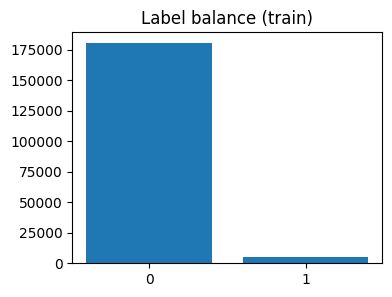

In [27]:
# Example: label balance in train
lab_counts = Counter()
labk = FIELD_MAP["label_key"]
for rec in stream_jsonl(FILES["train"]):
    if labk and labk in rec:
        lab_counts[normalize_label(rec[labk])] += 1

plt.figure(figsize=(4,3))
plt.bar([str(k) for k in lab_counts.keys()], list(lab_counts.values()))
plt.title("Label balance (train)")
plt.show()


# 4. look inside individual samples (code + patch) - opening the box

In [34]:
# Heuristic patterns for code/diff
CAND_DIFF  = re.compile(r"(diff|patch|hunk|unified)", re.I)
CAND_BEFORE= re.compile(r"(code_?before|before|old|pre)", re.I)
CAND_AFTER = re.compile(r"(code_?after|after|new|post)", re.I)

def find_content_fields(rec):
    diff_key=before_key=after_key=None
    for k in rec:
        if not diff_key and CAND_DIFF.search(k):   diff_key=k
        if not before_key and CAND_BEFORE.search(k): before_key=k
        if not after_key and CAND_AFTER.search(k):   after_key=k
    return diff_key, before_key, after_key

def show_one(fp: Path, i_target=1):
    for i, rec in enumerate(stream_jsonl(fp), 1):
        if i == i_target:
            diff_key, before_key, after_key = find_content_fields(rec)
            print(f"Keys: diff={diff_key}, before={before_key}, after={after_key}")
            # show some meta
            for name in ["cve","cwe","repo","project","file","path","commit","message","lang","label","is_vuln"]:
                for k in rec:
                    if name in k.lower():
                        print(f"{k}: {str(rec[k])[:240]}")
            # print diff or synthetic diff
            if diff_key and rec.get(diff_key):
                print("\n--- DIFF ---")
                print(str(rec[diff_key])[:2000])
            elif before_key and after_key and rec.get(before_key) and rec.get(after_key):
                print("\n--- UNIFIED DIFF (computed) ---")
                a = str(rec[before_key]).splitlines(keepends=False)
                b = str(rec[after_key]).splitlines(keepends=False)
                udiff = difflib.unified_diff(a, b, lineterm="")
                print("\n".join(list(itertools.islice(udiff, 400))))
            else:
                print("\n(No obvious diff/code fields found.)")
            break

# Example: show the 3rd training record with all available context
show_one(FILES["train"], i_target=3)


Keys: diff=None, before=None, after=None
cve_id: CVE-2017-2583
cve_language: C
cve_description: The load_segment_descriptor implementation in arch/x86/kvm/emulate.c in the Linux kernel before 4.9.5 improperly emulates a "MOV SS, NULL selector" instruction, which allows guest OS users to cause a denial of service (guest OS crash) or ga
cwe_id: ['CWE-264', 'NVD-CWE-noinfo']
cwe_description: 
cwe_consequence: 
cwe_method: 
cwe_solution: 
project: torvalds/linux
file_path: files/2017_2/129
file_name: arch/x86/kvm/emulate.c
file_language: c
file_target: -1
file_path: files/2017_2/129
commit_id: 33ab91103b3415e12457e3104f0e4517ce12d0f3
commit_message: KVM: x86: fix emulation of "MOV SS, null selector"

This is CVE-2017-2583.  On Intel this causes a failed vmentry because
SS's type is neither 3 nor 7 (even though the manual says this check is
only done for usable SS, and the dmesg splat s
commit_date: 2017-01-12T14:17:13Z
commit_message: KVM: x86: fix emulation of "MOV SS, null selector"

Thi

# 5. Inter procedural context (caller/calee tree, if present)

In [35]:
CAND_CALLER = re.compile(r"(caller|parents|incoming)", re.I)
CAND_CALLEE = re.compile(r"(callee|children|outgoing)", re.I)
CAND_CG     = re.compile(r"(call[_-]?graph|cg)", re.I)

def summarize_call_context(fp: Path, sample_n=5000):
    n=0; caller_sizes=[]; callee_sizes=[]; edges=[]
    keys_seen=set()
    for rec in stream_jsonl(fp):
        n+=1
        # discover keys
        ck = next((k for k in rec if CAND_CALLER.search(k)), None)
        dk = next((k for k in rec if CAND_CALLEE.search(k)), None)
        gk = next((k for k in rec if CAND_CG.search(k)), None)
        keys_seen.update([k for k in [ck,dk,gk] if k])

        # sizes
        if ck and isinstance(rec[ck], (list, tuple)): caller_sizes.append(len(rec[ck]))
        if dk and isinstance(rec[dk], (list, tuple)): callee_sizes.append(len(rec[dk]))
        if gk and isinstance(rec[gk], dict):
            # assume adjacency dict: node -> list(neighbors)
            m = sum(len(v) for v in rec[gk].values())
            edges.append(m)

        if n>=sample_n: break

    def safe_stats(xs):
        if not xs: return "n/a"
        return f"n={len(xs)}, mean={sum(xs)/len(xs):.2f}, max={max(xs)}"
    print("Keys observed:", keys_seen)
    print("Caller list sizes:", safe_stats(caller_sizes))
    print("Callee list sizes:", safe_stats(callee_sizes))
    print("Call-graph edge counts:", safe_stats(edges))

summarize_call_context(FILES["train"])


Keys observed: {'parents', 'callee'}
Caller list sizes: n=5000, mean=1.04, max=2
Callee list sizes: n/a
Call-graph edge counts: n/a


In [39]:
def visualize_callgraph_from_record(rec, cg_key_regex=CAND_CG, max_nodes=60):
    cg_key = next((k for k in rec if cg_key_regex.search(k)), None)
    if not cg_key or not isinstance(rec[cg_key], dict):
        print("No adjacency-like call_graph found.")
        return
    adj = rec[cg_key]
    G = nx.DiGraph()
    for u, neigh in adj.items():
        for v in (neigh or []):
            G.add_edge(str(u), str(v))
    # downsample if huge
    if len(G) > max_nodes:
        keep = list(itertools.islice(G.nodes(), max_nodes))
        G = G.subgraph(keep).copy()
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(G, k=0.4, seed=42)
    nx.draw(G, pos, with_labels=False, node_size=80, arrows=True)
    plt.title(f"Call graph (|V|={G.number_of_nodes()}, |E|={G.number_of_edges()})")
    plt.show()

# try on a record that actually has a call graph
for rec in stream_jsonl(FILES["train"], limit=1000):
    if any(CAND_CG.search(k) for k in rec):
        visualize_callgraph_from_record(rec); break



# Test 

In [40]:
import re
from collections import Counter, defaultdict

# look anywhere in the JSON object (nested) for keys matching these
RX_CALLER = re.compile(r"(caller|parents|incoming)", re.I)
RX_CALLEE = re.compile(r"(callee|children|outgoing)", re.I)
RX_CG     = re.compile(r"(call[_-]?graph|cg)", re.I)

def walk(obj, path=""):
    if isinstance(obj, dict):
        for k, v in obj.items():
            p = f"{path}.{k}" if path else k
            yield p, v
            yield from walk(v, p)
    elif isinstance(obj, list):
        for i, v in enumerate(obj):
            p = f"{path}[{i}]"
            yield p, v
            yield from walk(v, p)

def match_paths(rec, rx):
    out = []
    for p, v in walk(rec):
        base = p.rsplit(".", 1)[-1]  # last key segment
        if rx.search(base):
            out.append((p, v))
    return out

def sample_paths(fp, n=1000):
    caller_paths = Counter()
    callee_paths = Counter()
    cg_paths     = Counter()
    caller_types = Counter()
    callee_types = Counter()
    cg_types     = Counter()
    examples     = defaultdict(list)

    for i, rec in enumerate(stream_jsonl(fp), 1):
        for p, v in match_paths(rec, RX_CALLER):
            caller_paths[p] += 1
            caller_types[type(v).__name__] += 1
            if len(examples[p]) < 2:
                examples[p].append(v)
        for p, v in match_paths(rec, RX_CALLEE):
            callee_paths[p] += 1
            callee_types[type(v).__name__] += 1
            if len(examples[p]) < 2:
                examples[p].append(v)
        for p, v in match_paths(rec, RX_CG):
            cg_paths[p] += 1
            cg_types[type(v).__name__] += 1
            if len(examples[p]) < 2:
                examples[p].append(v)
        if i >= n:
            break

    def report(name, paths, types):
        print(f"\n== {name} ==")
        print("Top paths:")
        for p, c in paths.most_common(10):
            print(f"  {p:60s}  ~ {c}")
        print("Value types:", dict(types))

    report("CALLER", caller_paths, caller_types)
    report("CALLEE", callee_paths, callee_types)
    report("CALL_GRAPH", cg_paths, cg_types)

    # show a couple of raw examples for the most common path per category
    for title, paths in [("CALLER", caller_paths), ("CALLEE", callee_paths), ("CALL_GRAPH", cg_paths)]:
        if paths:
            p0 = paths.most_common(1)[0][0]
            print(f"\nExamples for {title} path: {p0}")
            for ex in examples[p0]:
                print("  ->", (str(ex)[:300] + "...") if len(str(ex)) > 300 else ex)

sample_paths(FILES["train"], n=3000)



== CALLER ==
Top paths:
  parents                                                       ~ 3000
  parents[0]                                                    ~ 3000
  caller                                                        ~ 3000
  caller_of_change                                              ~ 3000
  parents[1]                                                    ~ 115
  callee.tester.belle_sip_dialog_tester.caller_process_response_event  ~ 1
  callee.libvncclient.listen.listenForIncomingConnections       ~ 1
  callee.libvncclient.listen.listenForIncomingConnectionsNoFork  ~ 1
  callee.tools.zcall.conv.calling_incoming                      ~ 1
Value types: {'list': 3000, 'dict': 9115, 'str': 4}

== CALLEE ==
Top paths:
  callee                                                        ~ 3000
  callee_of_change                                              ~ 3000
  callee.tests.index.cache.test_index_cache__read_tree_no_children  ~ 2
  callee.tests.index.cache.test_index_cache__read_

In [41]:
def value_len(x):
    """Return a sensible 'size' for different shapes."""
    if x is None: return 0
    if isinstance(x, (list, tuple, set)): return len(x)
    if isinstance(x, dict): return sum(len(v or []) for v in x.values())  # adjacency dict
    if isinstance(x, str): return 1 if x.strip() else 0
    return 0

def summarize_callers_callees(fp, sample_n=100000):
    caller_count = callee_count = 0
    caller_sizes = []
    callee_sizes = []
    cg_edge_counts = []

    for i, rec in enumerate(stream_jsonl(fp), 1):
        # collect ALL matching paths in a record
        callers = match_paths(rec, RX_CALLER)
        callees = match_paths(rec, RX_CALLEE)
        cgraphs = match_paths(rec, RX_CG)

        if callers:
            # take the max 'size' among all caller-like fields present in this record
            sizes = [value_len(v) for _, v in callers]
            caller_sizes.append(max(sizes))
            caller_count += 1

        if callees:
            sizes = [value_len(v) for _, v in callees]
            callee_sizes.append(max(sizes))
            callee_count += 1

        if cgraphs:
            # if dict adjacency, count edges; else fallback to generic size
            for _, g in cgraphs:
                if isinstance(g, dict):
                    cg_edge_counts.append(sum(len(v or []) for v in g.values()))
                else:
                    cg_edge_counts.append(value_len(g))

        if i >= sample_n:
            break

    def stats(xs):
        if not xs: return "n=0"
        return f"n={len(xs)}, mean={sum(xs)/len(xs):.2f}, max={max(xs)}"

    print("Records scanned:", i)
    print("Records with ANY caller-like key  :", caller_count)
    print("Records with ANY callee-like key  :", callee_count)
    print("CALLER sizes:", stats(caller_sizes))
    print("CALLEE sizes:", stats(callee_sizes))
    print("Call-graph edges:", stats(cg_edge_counts))

summarize_callers_callees(FILES["train"])


Records scanned: 100000
Records with ANY caller-like key  : 100000
Records with ANY callee-like key  : 100000
CALLER sizes: n=100000, mean=745.27, max=2364309
CALLEE sizes: n=100000, mean=4086.15, max=3034810
Call-graph edges: n=286, mean=1.00, max=1


In [42]:
def raw_grep(fp, pattern, limit=5):
    import re, json
    rx = re.compile(pattern, re.I)
    hits = 0
    with fp.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if rx.search(line):
                hits += 1
                print(line[:400].rstrip(), "...")
                if hits >= limit:
                    break
    print(f"Total shown: {hits}")

print("\n--- Grep for callee ---")
raw_grep(FILES["train"], r'"callee"\s*:\s*(\[|".+?")', limit=10)

print("\n--- Grep for caller/parents ---")
raw_grep(FILES["train"], r'"(caller|parents)"\s*:\s*(\[|".+?")', limit=10)

print("\n--- Grep for call graph ---")
raw_grep(FILES["train"], r'"call[_-]?graph"', limit=10)



--- Grep for callee ---
Total shown: 0

--- Grep for caller/parents ---
{"function_id": "0a543725ccdd2a01669122ce79bb67e66ede77f2_75", "function": "int\npf_anchor_stack_is_empty(struct pf_anchor_stackframe *sf)\n{\n\tstruct pf_anchor_stackframe *stack;\n\tint rv;\n\n\tstack = (struct pf_anchor_stackframe *)cpumem_enter(pf_anchor_stack);\n\trv = (sf == &stack[0]);\n\tcpumem_leave(pf_anchor_stack, stack);\n\n\treturn (rv);\n}", "target": 0, "function_numbers": {"functio ...
{"function_id": "c0699c8693c47f14a2e57dec7292e862ac7adf9c_122", "function": "MOBI_RET mobi_parse_kf8(MOBIData *m) {\n    if (m == NULL) {\n        return MOBI_INIT_FAILED;\n    }\n    m->use_kf8 = true;\n    return MOBI_SUCCESS;\n}", "target": 0, "function_numbers": {"function_start": 3161, "function_end": 3167}, "line_numbers": [], "commit_id": "c0699c8693c47f14a2e57dec7292e862ac7adf9c", "cve_id" ...
{"function_id": "33ab91103b3415e12457e3104f0e4517ce12d0f3_8", "function": "static inline unsigned long ad_mask(struct

In [43]:
import re
from collections import Counter, defaultdict

RX_PARENTS = re.compile(r"(parents|caller|incoming)", re.I)

def walk(obj, path=""):
    if isinstance(obj, dict):
        for k, v in obj.items():
            p = f"{path}.{k}" if path else k
            yield p, v
            yield from walk(v, p)
    elif isinstance(obj, list):
        for i, v in enumerate(obj):
            p = f"{path}[{i}]"
            yield p, v
            yield from walk(v, p)

def find_parents_paths(fp, n=2000):
    paths, types = Counter(), Counter()
    example = {}
    for i, rec in enumerate(stream_jsonl(fp), 1):
        for p, v in walk(rec):
            base = p.rsplit(".", 1)[-1]
            if RX_PARENTS.search(base):
                paths[p]+=1
                types[type(v).__name__]+=1
                example.setdefault(p, v)
        if i>=n: break
    print("Parents value types:", dict(types))
    print("\nTop candidate paths:")
    for p, c in paths.most_common(8):
        print(f"  {p:60s} ~ {c}")
    if paths:
        p0 = paths.most_common(1)[0][0]
        print("\nExample value @", p0, ":\n", str(example[p0])[:500])
    return [p for p,_ in paths.most_common()]

PARENTS_PATHS = find_parents_paths(FILES["train"])


Parents value types: {'list': 2000, 'dict': 6073, 'str': 3}

Top candidate paths:
  parents                                                      ~ 2000
  parents[0]                                                   ~ 2000
  caller                                                       ~ 2000
  caller_of_change                                             ~ 2000
  parents[1]                                                   ~ 73
  callee.tester.belle_sip_dialog_tester.caller_process_response_event ~ 1
  callee.libvncclient.listen.listenForIncomingConnections      ~ 1
  callee.libvncclient.listen.listenForIncomingConnectionsNoFork ~ 1

Example value @ parents :
 [{'commit_id_before': '73be947e61bb3531e84a5f9836a6c50da1c8011d', 'url_before': 'https://api.github.com/repos/openbsd/src/commits/73be947e61bb3531e84a5f9836a6c50da1c8011d', 'html_url_before': 'https://github.com/openbsd/src/commit/73be947e61bb3531e84a5f9836a6c50da1c8011d'}]


In [44]:
def get_by_path(d, dotted):
    cur = d
    for seg in dotted.split("."):
        if seg.endswith("]"):  # ignore list indices in our path discovery
            seg = seg.split("[",1)[0]
        if isinstance(cur, dict) and seg in cur:
            cur = cur[seg]
        else:
            return None
    return cur

def extract_func_id(rec):
    # try common keys; fall back to function hash in your sample
    for k in rec:
        if k.lower() in {"function_id","func_id","id"}: return str(rec[k])
    # heuristic: sometimes the id is embedded in a path-like key
    return rec.get("function_id") or rec.get("func_id")

def edges_from_parents(fp, parents_paths=None, max_rows=200_000):
    if not parents_paths:
        parents_paths = PARENTS_PATHS[:3]  # top 3 guessed paths
    rows=[]
    for i, rec in enumerate(stream_jsonl(fp), 1):
        fid = extract_func_id(rec)
        if not fid: 
            continue
        parents_all=[]
        for p in parents_paths:
            v = get_by_path(rec, p)
            if v is None: 
                continue
            if isinstance(v, str):
                parents_all.append(v)
            elif isinstance(v, (list, tuple)):
                parents_all.extend([str(x) for x in v if x is not None])
            # if dict, skip (we only expect list/str for 'parents')
        parents_all = [x for x in parents_all if x]
        for parent in parents_all:
            rows.append((parent, fid))
        if i>=max_rows: 
            break
    return rows

caller_edges = edges_from_parents(FILES["train"])
print("edges (parent -> func):", len(caller_edges))


edges (parent -> func): 385472


|V|=47646, |E|=47209


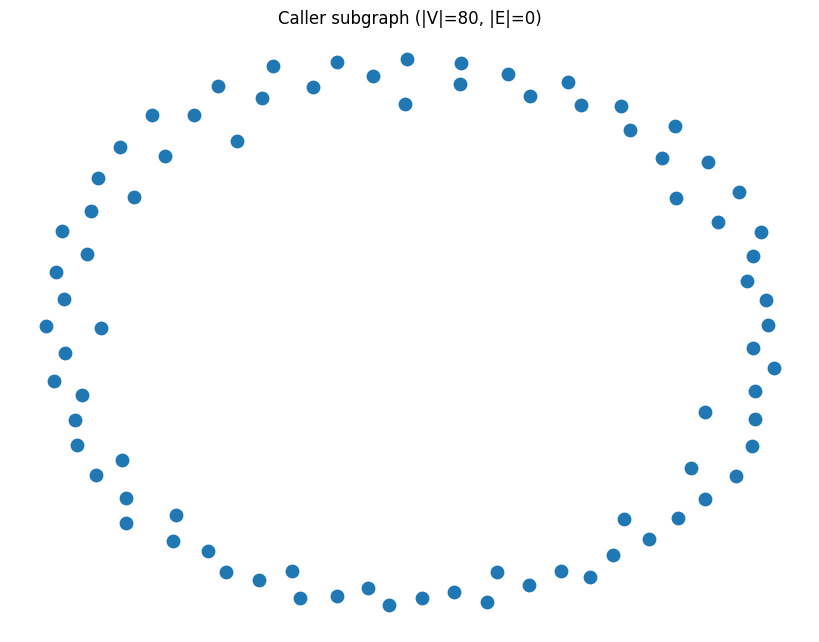

In [45]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def build_caller_graph(edges, max_nodes=50000):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    if G.number_of_nodes() > max_nodes:
        keep = set()
        for u,v in random.sample(edges, min(len(edges), max_nodes)):
            keep.add(u); keep.add(v)
        G = G.subgraph(keep).copy()
    return G

G_caller = build_caller_graph(caller_edges)
print(f"|V|={G_caller.number_of_nodes()}, |E|={G_caller.number_of_edges()}")

# visualize a small connected component (caller-centric)
def draw_cc(G, min_size=6, max_nodes=80):
    comps = [c for c in nx.weakly_connected_components(G) if len(c)>=min_size]
    if not comps:
        print("No connected components >= min_size.")
        return
    S = G.subgraph(list(next(iter(comps)))).copy()
    if S.number_of_nodes() > max_nodes:
        S = S.subgraph(list(list(S.nodes())[:max_nodes])).copy()
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(S, k=0.4, seed=42)
    nx.draw(S, pos, with_labels=False, node_size=80, arrows=True)
    plt.title(f"Caller subgraph (|V|={S.number_of_nodes()}, |E|={S.number_of_edges()})")
    plt.show()

draw_cc(G_caller)
